In [1]:
from __future__ import print_function

import os

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

Using TensorFlow backend.


In [2]:
class VGG_cifar10:
    def __init__(self, train=True, path='saved_models', weights_path=None):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]
        
        save_dir = os.path.join(os.getcwd(), path)
        model_name = 'VGG_cifar10_model.{epoch:03d}-{val_acc:.2f}.h5'
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        self.filepath = os.path.join(save_dir, model_name)
        
        print('Trained weights saving path ', self.filepath)
        

        self.model = self.build_model()
        if train:
            self.model = self.train()
        elif weights_path != None:
            print('Loading weights from ', weights_path)
            self.model.load_weights(weights_path)


    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model
    
    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)
    
    def train(self, epochs=None, model=None):
        #training parameters
        batch_size = 128
        maxepochs = 250 
        if (epochs != None):
            maxepochs = epochs
        if model == None:
            model = self.model
            
        print('Starting training for %s epochs'%maxepochs)
            
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20
        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=4,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=4,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

        checkpoint = ModelCheckpoint(filepath=self.filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

        # training process in a for loop with learning rate drop every 25 epochs.
        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepochs,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr, checkpoint],verbose=1)
#         model.save_weights('cifar10vgg.h5')
        return model

In [3]:
model_handle = VGG_cifar10(train=False)

Trained weights saving path  /root/workspace/bnn_p4/BaNaNa-split-binarization/baselines/saved_models/VGG_cifar10_model.{epoch:03d}-{val_acc:.2f}.h5


In [4]:
model_handle.train(epochs=300)

Starting training for 300 epochs
Epoch 1/300
390/390 [==============================] - 77s 198ms/step - loss: 29.3978 - acc: 0.1681 - val_loss: 21.7251 - val_acc: 0.1494

Epoch 00001: val_acc improved from -inf to 0.14940, saving model to /root/workspace/bnn_p4/BaNaNa-split-binarization/baselines/saved_models/VGG_cifar10_model.001-0.15.h5
Epoch 2/300
390/390 [==============================] - 69s 177ms/step - loss: 15.3776 - acc: 0.2282 - val_loss: 12.0382 - val_acc: 0.1578

Epoch 00002: val_acc improved from 0.14940 to 0.15780, saving model to /root/workspace/bnn_p4/BaNaNa-split-binarization/baselines/saved_models/VGG_cifar10_model.002-0.16.h5
Epoch 3/300
390/390 [==============================] - 69s 176ms/step - loss: 8.5841 - acc: 0.2416 - val_loss: 7.2442 - val_acc: 0.1399

Epoch 00003: val_acc did not improve from 0.15780
Epoch 4/300
390/390 [==============================] - 69s 177ms/step - loss: 6.7012 - acc: 0.1918 - val_loss: 5.8613 - val_acc: 0.1839

Epoch 00004: val_acc i


Epoch 00034: val_acc did not improve from 0.81930
Epoch 35/300
390/390 [==============================] - 72s 185ms/step - loss: 1.1309 - acc: 0.8180 - val_loss: 1.1974 - val_acc: 0.7971

Epoch 00035: val_acc did not improve from 0.81930
Epoch 36/300
390/390 [==============================] - 72s 184ms/step - loss: 1.1431 - acc: 0.8167 - val_loss: 1.1477 - val_acc: 0.8098

Epoch 00036: val_acc did not improve from 0.81930
Epoch 37/300
390/390 [==============================] - 71s 183ms/step - loss: 1.1391 - acc: 0.8199 - val_loss: 1.1110 - val_acc: 0.8291

Epoch 00037: val_acc improved from 0.81930 to 0.82910, saving model to /root/workspace/bnn_p4/BaNaNa-split-binarization/baselines/saved_models/VGG_cifar10_model.037-0.83.h5
Epoch 38/300
390/390 [==============================] - 71s 182ms/step - loss: 1.1490 - acc: 0.8190 - val_loss: 1.1636 - val_acc: 0.8151

Epoch 00038: val_acc did not improve from 0.82910
Epoch 39/300
390/390 [==============================] - 71s 183ms/step - l

390/390 [==============================] - 73s 187ms/step - loss: 0.6709 - acc: 0.9047 - val_loss: 0.6995 - val_acc: 0.8968

Epoch 00072: val_acc did not improve from 0.90000
Epoch 73/300
390/390 [==============================] - 73s 187ms/step - loss: 0.6685 - acc: 0.9037 - val_loss: 0.7120 - val_acc: 0.8878

Epoch 00073: val_acc did not improve from 0.90000
Epoch 74/300
390/390 [==============================] - 73s 186ms/step - loss: 0.6696 - acc: 0.9041 - val_loss: 0.7020 - val_acc: 0.8938

Epoch 00074: val_acc did not improve from 0.90000
Epoch 75/300
390/390 [==============================] - 72s 185ms/step - loss: 0.6712 - acc: 0.9049 - val_loss: 0.7135 - val_acc: 0.8901

Epoch 00075: val_acc did not improve from 0.90000
Epoch 76/300
390/390 [==============================] - 73s 186ms/step - loss: 0.6722 - acc: 0.9030 - val_loss: 0.7135 - val_acc: 0.8947

Epoch 00076: val_acc did not improve from 0.90000
Epoch 77/300
390/390 [==============================] - 73s 186ms/step - 


Epoch 00151: val_acc did not improve from 0.93500
Epoch 152/300
390/390 [==============================] - 72s 185ms/step - loss: 0.2618 - acc: 0.9817 - val_loss: 0.4535 - val_acc: 0.9349

Epoch 00152: val_acc did not improve from 0.93500
Epoch 153/300
390/390 [==============================] - 72s 185ms/step - loss: 0.2610 - acc: 0.9808 - val_loss: 0.4548 - val_acc: 0.9376

Epoch 00153: val_acc improved from 0.93500 to 0.93760, saving model to /root/workspace/bnn_p4/BaNaNa-split-binarization/baselines/saved_models/VGG_cifar10_model.153-0.94.h5
Epoch 154/300
390/390 [==============================] - 71s 182ms/step - loss: 0.2584 - acc: 0.9811 - val_loss: 0.4499 - val_acc: 0.9353

Epoch 00154: val_acc did not improve from 0.93760
Epoch 155/300
390/390 [==============================] - 72s 185ms/step - loss: 0.2548 - acc: 0.9826 - val_loss: 0.4573 - val_acc: 0.9367

Epoch 00155: val_acc did not improve from 0.93760
Epoch 156/300
390/390 [==============================] - 72s 186ms/ste

390/390 [==============================] - 72s 185ms/step - loss: 0.2091 - acc: 0.9906 - val_loss: 0.4422 - val_acc: 0.9388

Epoch 00233: val_acc did not improve from 0.93990
Epoch 234/300
390/390 [==============================] - 72s 185ms/step - loss: 0.2083 - acc: 0.9909 - val_loss: 0.4418 - val_acc: 0.9390

Epoch 00234: val_acc did not improve from 0.93990
Epoch 235/300
390/390 [==============================] - 72s 185ms/step - loss: 0.2090 - acc: 0.9906 - val_loss: 0.4419 - val_acc: 0.9385

Epoch 00235: val_acc did not improve from 0.93990
Epoch 236/300
390/390 [==============================] - 72s 185ms/step - loss: 0.2115 - acc: 0.9893 - val_loss: 0.4419 - val_acc: 0.9386

Epoch 00236: val_acc did not improve from 0.93990
Epoch 237/300
390/390 [==============================] - 72s 186ms/step - loss: 0.2098 - acc: 0.9904 - val_loss: 0.4416 - val_acc: 0.9383

Epoch 00237: val_acc did not improve from 0.93990
Epoch 238/300
390/390 [==============================] - 72s 185ms/st

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

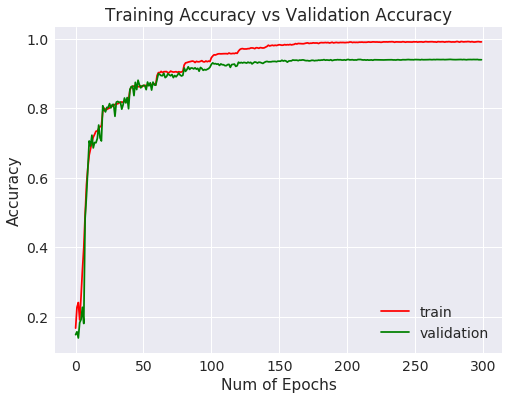

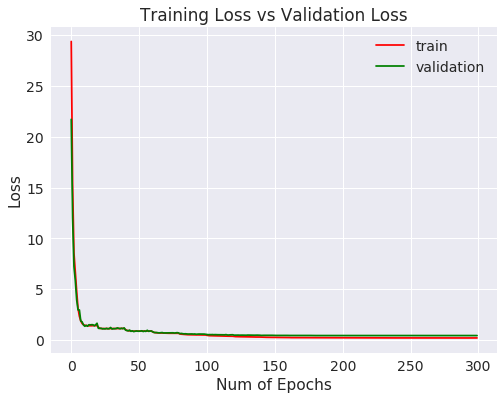

In [11]:
history = model_handle.model.history

plt.figure(0)
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'g')
# plt.xticks(np.arange(0, epochs, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
# plt.xticks(np.arange(0, epochs, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
 
plt.show()

In [12]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)
results = model_handle.predict(x=X_test)

In [14]:
boolarr = (np.argmax(results, axis=1) == y_test.reshape(-1))
print ('Correct %d/%d' % (np.sum(boolarr), X_test.shape[0]), '(Accuracy: %f)'% (np.sum(boolarr)/X_test.shape[0]))

Correct 9391/10000 (Accuracy: 0.939100)


[[951   1  13   3   1   0   3   2  19   7]
 [  4 970   2   0   0   0   0   0   5  19]
 [ 16   0 918  16  15   9  17   6   3   0]
 [  7   1  17 883  12  56  14   6   3   1]
 [  5   0  11  14 947  10   6   7   0   0]
 [  3   1   9  74  15 886   5   7   0   0]
 [  4   0  11  17   1   1 965   1   0   0]
 [  4   0   9   6  10  12   0 959   0   0]
 [ 16   2   4   3   0   0   2   0 965   8]
 [  4  31   1   4   0   0   1   0  12 947]]


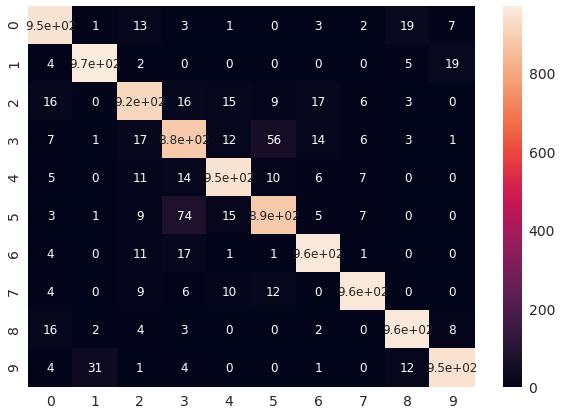

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(results, axis=1).reshape(10000,1)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd

df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

Credits: Code adapted from https://github.com/geifmany/cifar-vgg